In [4]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
import gradio as gr

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Cellphone_price_prediction/final_mobile_price_data.csv')
print("Original DataFrame shape:", df.shape)

Original DataFrame shape: (2000, 21)


In [6]:
print(df.head())
print("\nShape:", df.shape)


   battery_power  blue  clock_speed  dual_sim  fc  four_g  int_memory  m_dep  \
0            842     0          2.2         0   1       0           7    0.6   
1           1021     1          0.5         1   0       1          53    0.7   
2            563     1          0.5         1   2       1          41    0.9   
3            615     1          2.5         0   0       0          10    0.8   
4           1821     1          1.2         0  13       1          44    0.6   

   mobile_wt  n_cores  ...  px_height  px_width   ram  sc_h  sc_w  talk_time  \
0        188        2  ...         20       756  2549     9     7         19   
1        136        3  ...        905      1988  2631    17     3          7   
2        145        5  ...       1263      1716  2603    11     2          9   
3        131        6  ...       1216      1786  2769    16     8         11   
4        141        2  ...       1208      1212  1411     8     2         15   

   three_g  touch_screen  wifi  Price 

In [7]:
print("\nDescription:")
print(df.describe())


Description:
       battery_power       blue  clock_speed     dual_sim           fc  \
count    2000.000000  2000.0000  2000.000000  2000.000000  2000.000000   
mean     1238.518500     0.4950     1.522250     0.509500     4.309500   
std       439.418206     0.5001     0.816004     0.500035     4.341444   
min       501.000000     0.0000     0.500000     0.000000     0.000000   
25%       851.750000     0.0000     0.700000     0.000000     1.000000   
50%      1226.000000     0.0000     1.500000     1.000000     3.000000   
75%      1615.250000     1.0000     2.200000     1.000000     7.000000   
max      1998.000000     1.0000     3.000000     1.000000    19.000000   

            four_g   int_memory        m_dep    mobile_wt      n_cores  ...  \
count  2000.000000  2000.000000  2000.000000  2000.000000  2000.000000  ...   
mean      0.521500    32.046500     0.501750   140.249000     4.520500  ...   
std       0.499662    18.145715     0.288416    35.399655     2.287837  ...   
min

In [8]:
print("\nInfo:")
df.info()


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   battery_power  2000 non-null   int64  
 1   blue           2000 non-null   int64  
 2   clock_speed    2000 non-null   float64
 3   dual_sim       2000 non-null   int64  
 4   fc             2000 non-null   int64  
 5   four_g         2000 non-null   int64  
 6   int_memory     2000 non-null   int64  
 7   m_dep          2000 non-null   float64
 8   mobile_wt      2000 non-null   int64  
 9   n_cores        2000 non-null   int64  
 10  pc             2000 non-null   int64  
 11  px_height      2000 non-null   int64  
 12  px_width       2000 non-null   int64  
 13  ram            2000 non-null   int64  
 14  sc_h           2000 non-null   int64  
 15  sc_w           2000 non-null   int64  
 16  talk_time      2000 non-null   int64  
 17  three_g        2000 non-null   int64  
 18  t

In [9]:
print("\nMissing values:")
print(df.isnull().sum())


Missing values:
battery_power    0
blue             0
clock_speed      0
dual_sim         0
fc               0
four_g           0
int_memory       0
m_dep            0
mobile_wt        0
n_cores          0
pc               0
px_height        0
px_width         0
ram              0
sc_h             0
sc_w             0
talk_time        0
three_g          0
touch_screen     0
wifi             0
Price            0
dtype: int64


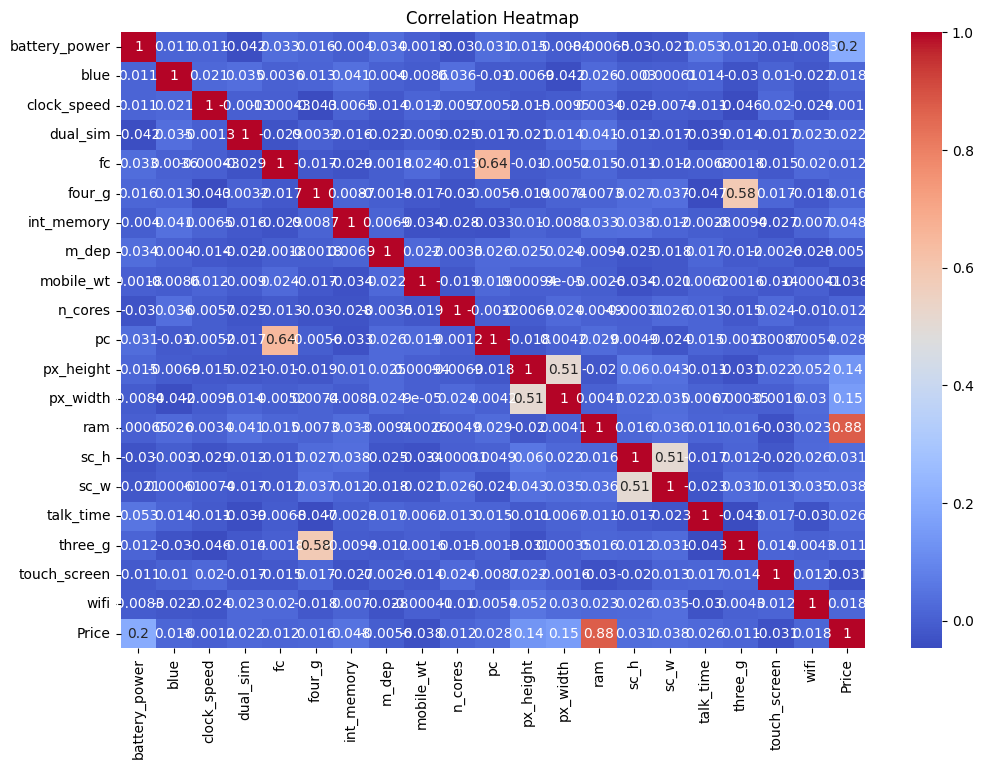

In [10]:
# Plot correlation heatmap (Optional but good for analysis)
plt.figure(figsize=(12,8))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm') # Use numeric_only=True
plt.title('Correlation Heatmap')
plt.show()

In [11]:
# Select numerical columns except the target for boxplots
numerical_cols_for_plots = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

In [12]:
# Remove 'Price' safely
if 'Price' in numerical_cols_for_plots:
    numerical_cols_for_plots.remove('Price')

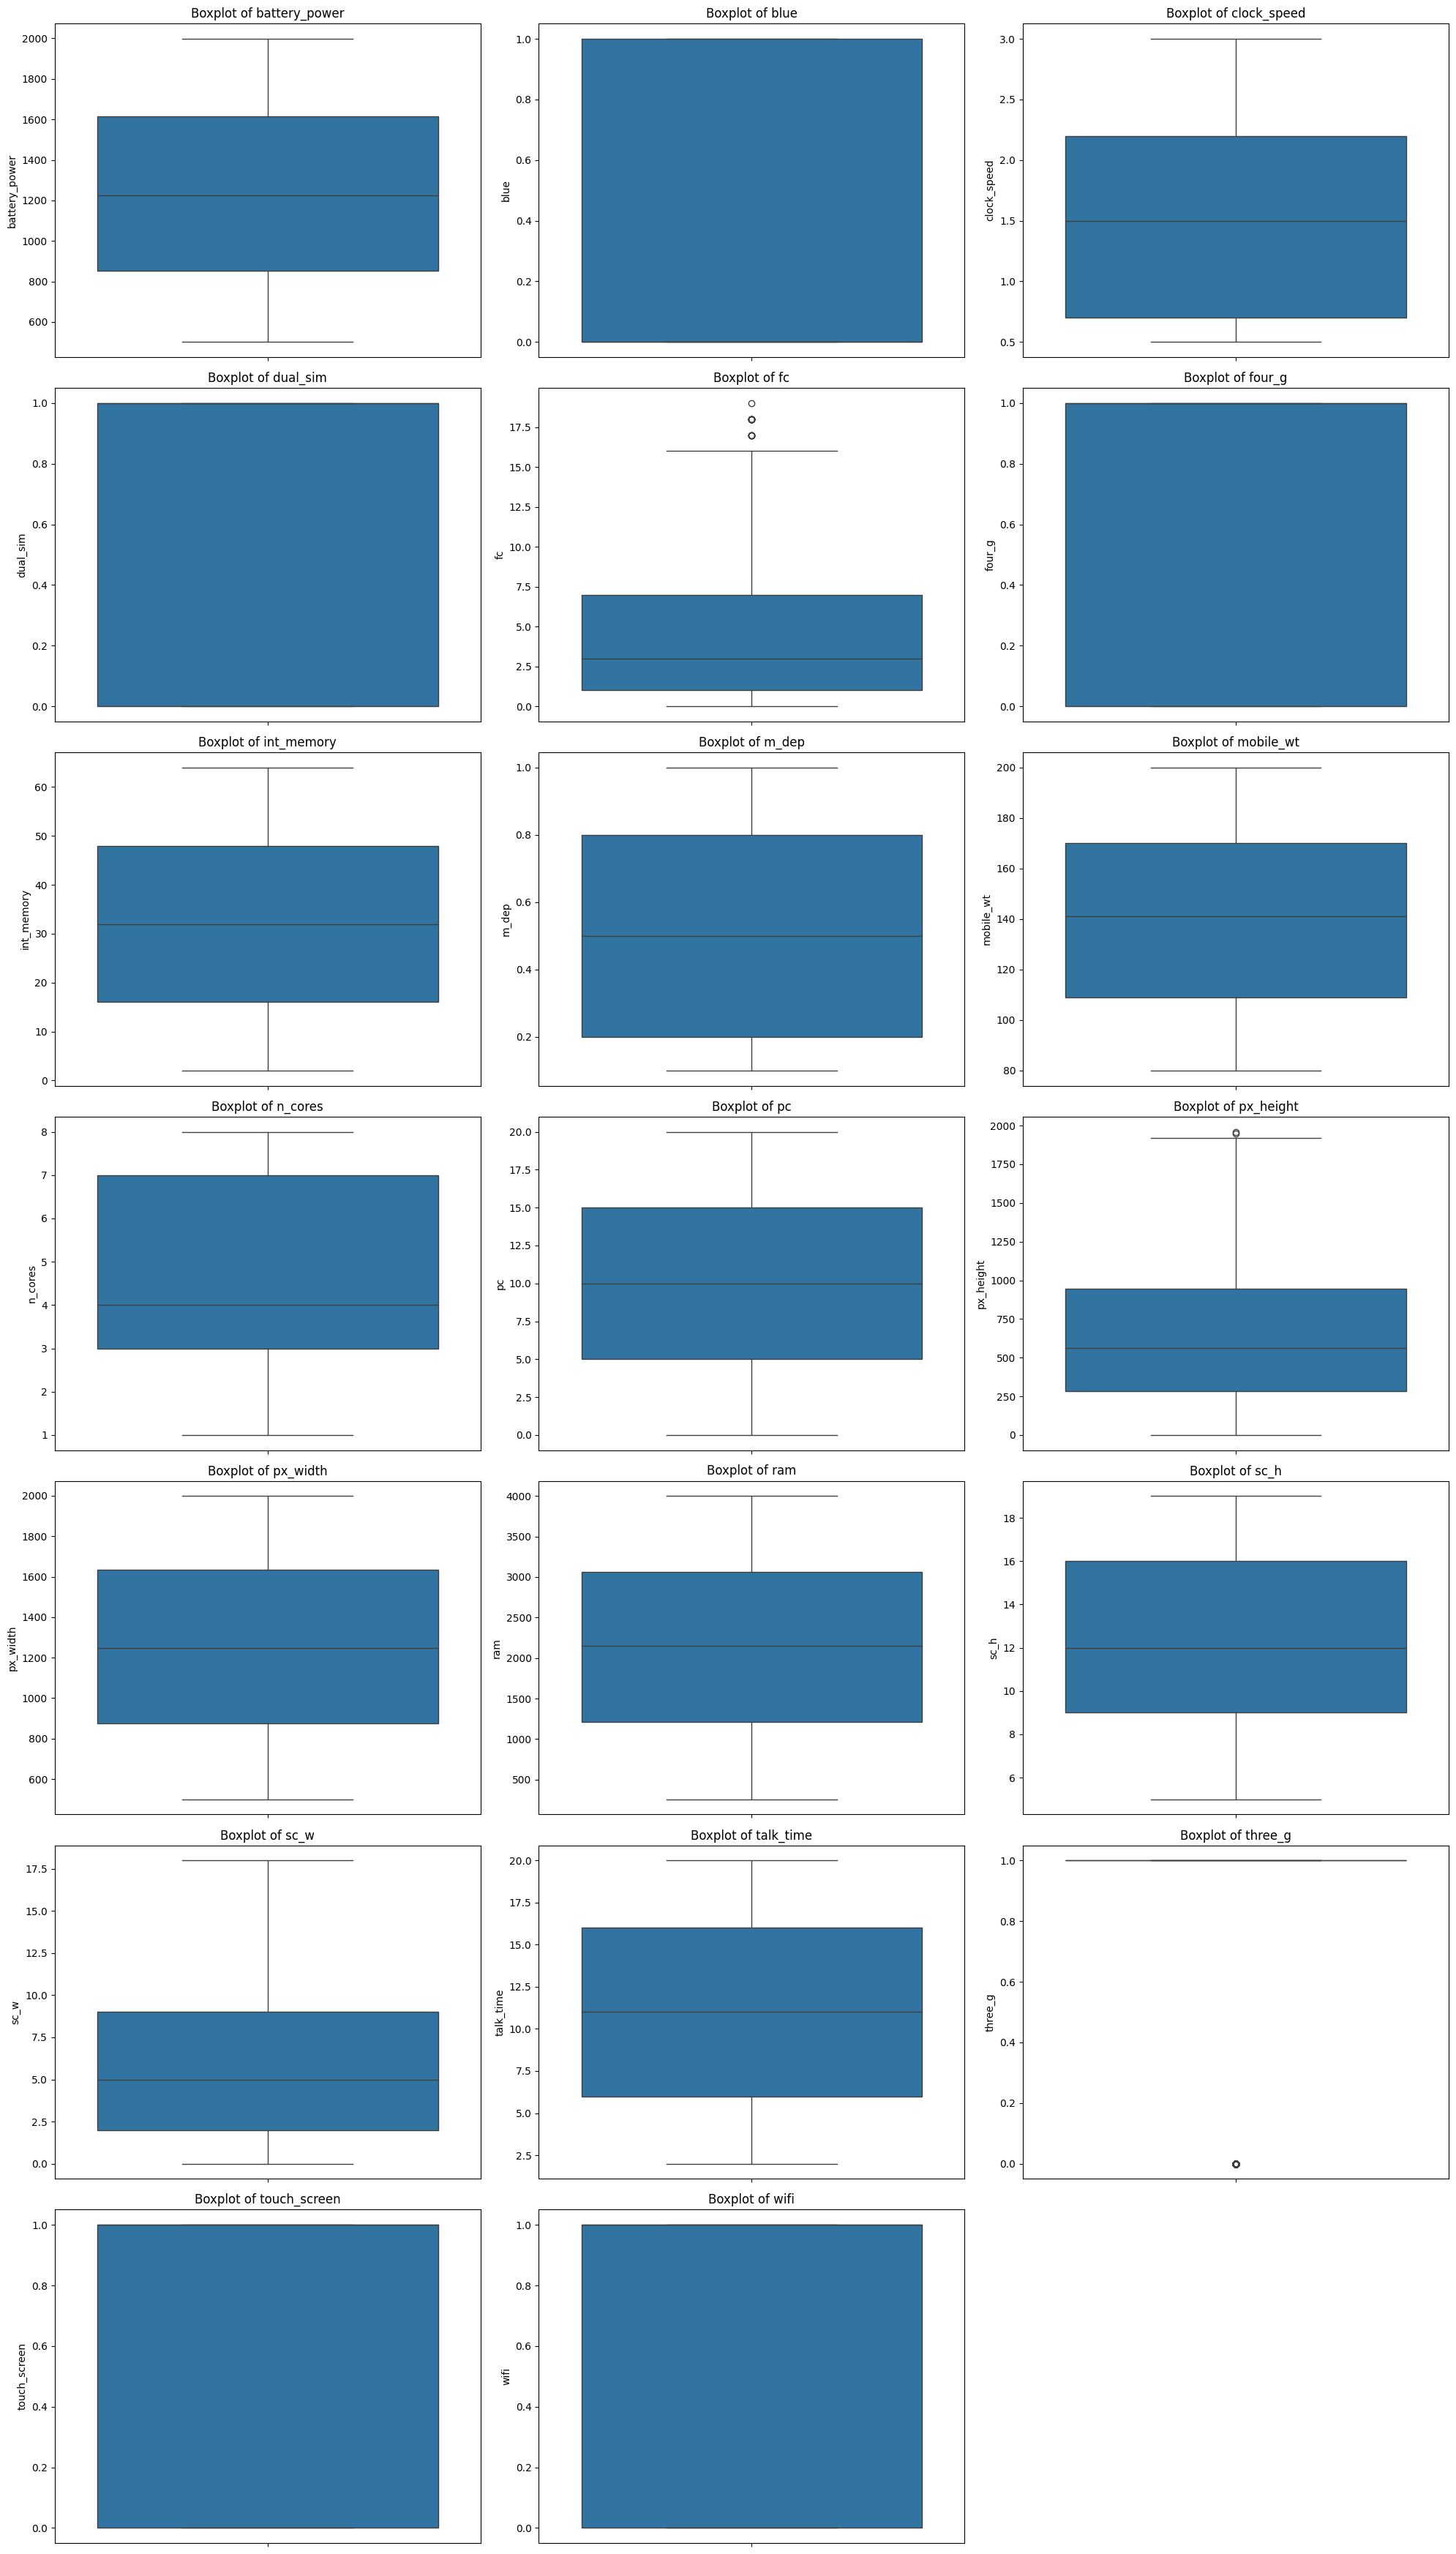

In [13]:
# Plot boxplots for numerical columns (Optional but good for analysis)
# Adjust plot layout based on the number of columns
n_cols = len(numerical_cols_for_plots)
n_rows = (n_cols + 2) // 3 # Integer division to get number of rows needed
plt.figure(figsize=(20, n_rows * 5)) # Adjust figure height
for idx, col in enumerate(numerical_cols_for_plots):
    plt.subplot(n_rows, 3, idx + 1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
plt.tight_layout()
plt.show()

In [14]:
# Detect and remove outliers using IQR method
def remove_outliers_iqr(df_input, columns):
    df_output = df_input.copy() # Create a copy to avoid modifying the original df in place repeatedly in loops
    for col in columns:
        Q1 = df_output[col].quantile(0.25)
        Q3 = df_output[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        # Apply filter and update the df_output in each iteration
        df_output = df_output[(df_output[col] >= lower_bound) & (df_output[col] <= upper_bound)]
    return df_output


In [15]:
# Select numerical columns for outlier removal (excluding target)
numerical_cols_for_outliers = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
if 'Price' in numerical_cols_for_outliers:
    numerical_cols_for_outliers.remove('Price')

In [16]:
# Apply outlier removal
# Create a *new* dataframe `df_cleaned` after outlier removal
df_cleaned = remove_outliers_iqr(df, numerical_cols_for_outliers)

print("Shape after outlier removal:", df_cleaned.shape)
print("Number of rows removed:", df.shape[0] - df_cleaned.shape[0])


Shape after outlier removal: (1506, 21)
Number of rows removed: 494


In [17]:
# --- Feature Selection ---
# List of the selected features for the model and Gradio interface
selected_features = [
    'ram', 'battery_power', 'px_height', 'px_width',
    'int_memory', 'mobile_wt', 'pc', 'sc_w'
]

In [18]:
# Define the target column
target_column = 'Price' # Adjust if your target column name is different


In [19]:
# --- Verify if selected features and target column exist in the *cleaned* DataFrame ---
missing_features_cleaned = [col for col in selected_features if col not in df_cleaned.columns]
if missing_features_cleaned:
    print(f"Error: The following selected features are not found in the *cleaned* DataFrame: {missing_features_cleaned}")
    print("Please check your 'selected_features' list against df_cleaned.columns:")
    print(df_cleaned.columns.tolist())
    raise KeyError(f"Missing features in cleaned DataFrame: {missing_features_cleaned}")

if target_column not in df_cleaned.columns:
    print(f"Error: The target column '{target_column}' is not found in the *cleaned* DataFrame.")
    print("Please check your 'target_column' name against df_cleaned.columns:")
    print(df_cleaned.columns.tolist())
    raise KeyError(f"Target column not found in cleaned DataFrame: {target_column}")

In [20]:
# Select features (X) and target (y) from the *cleaned* dataframe using the selected features
X = df_cleaned[selected_features]
y = df_cleaned[target_column] # y remains unscaled
print("\nShape of X (selected features):", X.shape)
print("Shape of y (target):", y.shape)


Shape of X (selected features): (1506, 8)
Shape of y (target): (1506,)


In [21]:
# --- Split Data ---
# Split the data (X with selected features, y unscaled) into training, validation, and test sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_val.shape}")
print(f"Test set size: {X_test.shape}")
print(f"y_train shape: {y_train.shape}") # Check y shapes too


Training set size: (1054, 8)
Validation set size: (226, 8)
Test set size: (226, 8)
y_train shape: (1054,)


In [22]:
# --- Scale Features ---
# Fit a StandardScaler *only* on the X_train data (which has selected features)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [23]:
# Transform X_val and X_test using the *same* fitted scaler
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Convert scaled arrays back to DataFrames for consistency if needed later (optional but good practice)
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled_df = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("\nShape of scaled X_train:", X_train_scaled.shape)


Shape of scaled X_train: (1054, 8)


Linear Regression - MAE: 5277.826502477228, RMSE: 6608.602504692766, R²: 0.8427514046305915


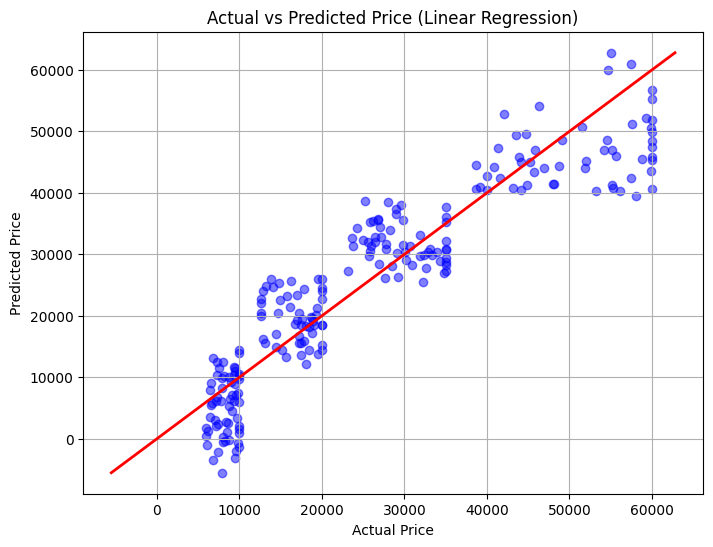

In [25]:
# --- Train Models (Using Scaled X and Unscaled Y) ---

# Linear Regression
lr = LinearRegression()
lr.fit(X_train_scaled, y_train) # Train LR on scaled features and unscaled target

# %%
# Predict using LR and evaluate
y_pred_lr = lr.predict(X_test_scaled) # Predict using scaled test features

# Evaluate LR
mae_lr = mean_absolute_error(y_test, y_pred_lr)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression - MAE: {mae_lr}, RMSE: {rmse_lr}, R²: {r2_lr}')


# Actual vs Predicted Plot for LR (Optional visualization)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_lr, color='blue', alpha=0.5)
# Plot the 45-degree line for reference
min_max = [min(y_test.min(), y_pred_lr.min()), max(y_test.max(), y_pred_lr.max())]
plt.plot(min_max, min_max, color='red', lw=2)
plt.title('Actual vs Predicted Price (Linear Regression)')
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.grid(True)
plt.show()

In [26]:
# Random Forest (using GridSearchCV)
rf_params = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10],
    'min_samples_split': [2, 10]
}

rf_model = RandomForestRegressor(random_state=42)
# Fit GridSearchCV on scaled training features and unscaled training target
rf_grid = GridSearchCV(rf_model, rf_params, cv=3, scoring='neg_mean_squared_error')
rf_grid.fit(X_train_scaled, y_train) # Fit on scaled X_train

print("Best Random Forest Params:", rf_grid.best_params_)

Best Random Forest Params: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}


In [27]:
# KNN Regressor
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
# Train KNN on scaled training features and unscaled training target
knn.fit(X_train_scaled, y_train) # Fit on scaled X_train

# Predict using KNN and evaluate
y_pred_knn = knn.predict(X_test_scaled) # Predict using scaled test features

# Evaluate KNN
mae_knn = mean_absolute_error(y_test, y_pred_knn)
rmse_knn = np.sqrt(mean_squared_error(y_test, y_pred_knn))
r2_knn = r2_score(y_test, y_pred_knn)

print(f'KNN - MAE: {mae_knn}, RMSE: {rmse_knn}, R²: {r2_knn}')

KNN - MAE: 5875.886725663717, RMSE: 7560.851510574437, R²: 0.7941698780496647


In [28]:
# Gradient Boosting Regressor (using GridSearchCV)
gb_params = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5]
}

gb_model = GradientBoostingRegressor(random_state=42)
# Fit GridSearchCV on scaled training features and unscaled training target
gb_grid = GridSearchCV(gb_model, gb_params, cv=3, scoring='neg_mean_squared_error')
gb_grid.fit(X_train_scaled, y_train) # Fit on scaled X_train

print("Best Gradient Boosting Params:", gb_grid.best_params_)


Best Gradient Boosting Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100}


In [29]:
# --- Model Evaluation Summary ---

models = {
    "Linear Regression": lr, # LR is already trained on scaled data
    "Random Forest": rf_grid.best_estimator_, # Use the best estimator, trained on scaled data
    "KNN": knn, # KNN is already trained on scaled data
    # Use the best estimator for GB as well, trained on scaled data
    "Gradient Boosting": gb_grid.best_estimator_
}

results = []
# Use the scaled test set for prediction here
for name, model in models.items():
    y_pred = model.predict(X_test_scaled) # Predict using scaled test features
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # Evaluate against unscaled y_test
    mae  = mean_absolute_error(y_test, y_pred)       # Evaluate against unscaled y_test
    r2   = r2_score(y_test, y_pred)                  # Evaluate against unscaled y_test
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R-squared': r2
    })

results_df = pd.DataFrame(results)
print("\nModel Evaluation Results:")
print(results_df)


Model Evaluation Results:
               Model         RMSE          MAE  R-squared
0  Linear Regression  6608.602505  5277.826502   0.842751
1      Random Forest  5716.116334  4226.821792   0.882356
2                KNN  7560.851511  5875.886726   0.794170
3  Gradient Boosting  5934.555458  4602.224728   0.873193


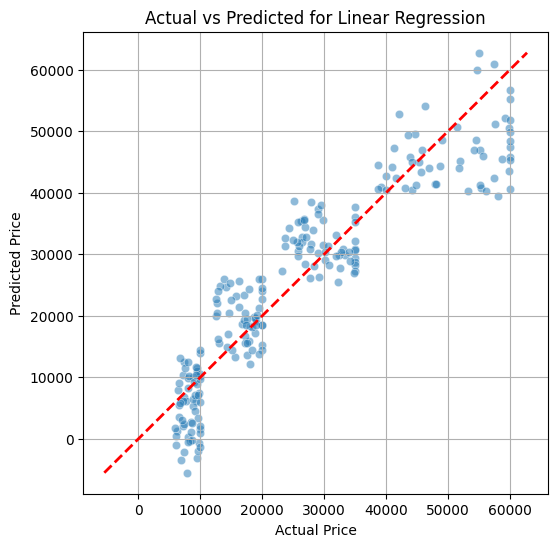

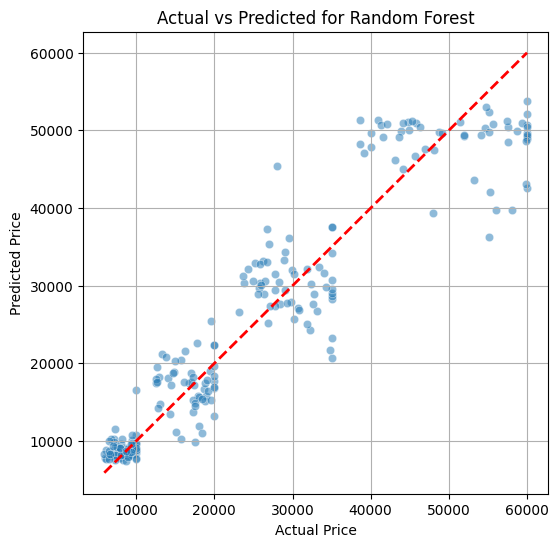

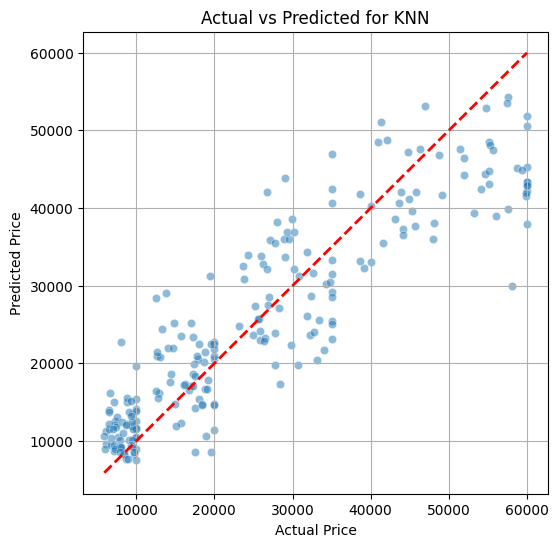

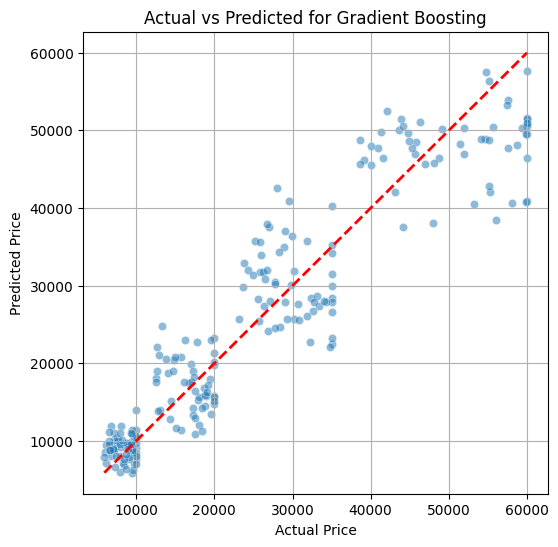


Columns in the cleaned DataFrame: ['battery_power', 'blue', 'clock_speed', 'dual_sim', 'fc', 'four_g', 'int_memory', 'm_dep', 'mobile_wt', 'n_cores', 'pc', 'px_height', 'px_width', 'ram', 'sc_h', 'sc_w', 'talk_time', 'three_g', 'touch_screen', 'wifi', 'Price']
Selected features: ['ram', 'battery_power', 'px_height', 'px_width', 'int_memory', 'mobile_wt', 'pc', 'sc_w']


In [30]:
# --- Plot Actual vs Predicted for all models ---
import matplotlib.pyplot as plt
import seaborn as sns

# Use the scaled test set for prediction
for name, model in models.items():
    y_pred = model.predict(X_test_scaled) # Predict using scaled X_test

    plt.figure(figsize=(6, 6))
    # Plot actual (y_test) vs predicted (y_pred - unscaled)
    sns.scatterplot(x=y_test, y=y_pred, alpha=0.5)
    # Plot the 45-degree line for reference
    min_max = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
    plt.plot(min_max, min_max, '--r', lw=2)
    plt.xlabel('Actual Price')
    plt.ylabel('Predicted Price')
    plt.title(f'Actual vs Predicted for {name}')
    plt.grid(True)
    plt.show()

# %%
print("\nColumns in the cleaned DataFrame:", df_cleaned.columns.tolist())
print("Selected features:", selected_features)


In [31]:
# --- Gradio Interface ---

# Re-import gradio in case the previous cell failed (already imported above, but harmless)
try:
    import gradio as gr
except ImportError:
    !pip install gradio==3.50.0
    import gradio as gr

# Ensure 'model' and 'scaler' variables are available from the previous training steps
# 'model' should be the best estimator from rf_grid, trained on scaled features and unscaled target
# 'scaler' should be fitted on the X_train (selected features)

# Define the Prediction Function for Gradio
def predict_price(
    ram, battery_power, px_height, px_width,
    int_memory, mobile_wt, pc, sc_w
):
    # Create input dictionary with selected features
    data = {
        'ram': [ram],
        'battery_power': [battery_power],
        'px_height': [px_height],
        'px_width': [px_width],
        'int_memory': [int_memory],
        'mobile_wt': [mobile_wt],
        'pc': [pc],
        'sc_w': [sc_w]
    }

    # Convert to DataFrame
    input_df = pd.DataFrame(data)

    # Ensure the input DataFrame has columns in the same order as the training data
    # This is crucial for consistent scaling and prediction
    # Use the list of columns from the fitted scaler or X_train_scaled_df
    try:
        # Use the columns from the original X_train DataFrame (before scaling)
        # This ensures the order matches the scaler's expected input order
        input_df = input_df[X_train.columns]
    except Exception as e:
        return f"Column Ordering Error: {e}"


    # Scale the input features using the *fitted* scaler
    try:
        scaled_input = scaler.transform(input_df)
    except Exception as e:
        return f"Scaling Error: {e}"

    # Make prediction using the model trained on scaled features -> unscaled target
    # The output 'prediction' will be in the original price scale (Rupees)
    try:
        prediction = model.predict(scaled_input)[0]
    except Exception as e:
        return f"Prediction Error: {e}"

    # Return the prediction directly in the original price scale
    return f"Predicted Price: ₹{prediction:,.2f}"

# --- Create and Launch the Gradio Interface ---

interface = gr.Interface(
    fn=predict_price,
    inputs=[
        gr.Number(label="RAM (MB)"),
        gr.Number(label="Battery Power (mAh)"),
        gr.Number(label="Pixel Height"),
        gr.Number(label="Pixel Width"),
        gr.Number(label="Internal Memory (GB)"),
        gr.Number(label="Mobile Weight (grams)"),
        gr.Number(label="Primary Camera (MP)"),
        gr.Number(label="Screen Width (cm)"),
    ],
    outputs="text",
    title="Cellphone Price Predictor (Top 8 Features)"
)

interface.launch(share=True, debug=True)

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://577a84db2d860638f4.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://577a84db2d860638f4.gradio.live
